# Cumulative Distribution Functions

Frequency tables and PMFs are the most familiar ways to represent distributions, but as we’ll see in this chapter, they have limitations. An alternative is the cumulative distribution function (CDF), which is useful for computing percentiles, and especially useful for comparing distributions.

Also in this chapter, we’ll compute percentile-based statistics to quantify the location, spread, and skewness of a distribution.
https://allendowney.github.io/ThinkStats/chap04.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

## Percentiles and Percentile Ranks

If you have taken a standardized test, you probably got your results in the form of a raw score and a percentile rank. In this context, the percentile rank is the percentage of people who got the same score as you or lower. So if you are “in the 90th percentile,” you did as well as or better than 90% of the people who took the exam.

To understand percentiles and percentile ranks, let’s consider an example based on running speeds. Some years ago I ran the James Joyce Ramble, which is a 10 kilometer road race in Massachusetts. After the race, I downloaded the results to see how my time compared to other runners.

In [2]:
def download(url, path="datasets"):
    content = requests.get(url).content

    with open(f"{path + url.split('/')[-1]}", mode="wb") as file:
        file.write(content)

In [3]:
#download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/relay.py", path="")
#download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/Apr25_27thAn_set1.shtml", path="datasets/relay/")

In [4]:
from relay import read_results

results = read_results()
results.head()

,Place,Div/Tot,Division,Guntime,Nettime,Min/Mile,MPH
0,1,1/362,M2039,30:43,30:42,4:57,12.121212
1,2,2/362,M2039,31:36,31:36,5:06,11.764706
2,3,3/362,M2039,31:42,31:42,5:07,11.726384
3,4,4/362,M2039,32:28,32:27,5:14,11.464968
4,5,5/362,M2039,32:52,32:52,5:18,11.320755


In [5]:
speeds = results["MPH"].values

In [7]:
my_result = results.query("Nettime == '42:44'")
my_result

,Place,Div/Tot,Division,Guntime,Nettime,Min/Mile,MPH
96,97,26/256,M4049,42:48,42:44,6:53,8.716707


In [9]:
my_speed = speeds[96]
(speeds <= my_speed).sum()

1537

In [14]:
(speeds <= my_speed).mean()*100
#The result is my percentile rank in the field, which was about 94%.

94.12124923453766

In [19]:
def percentile_rank(x, seq):
    """Percentile rank of x.

    x: value
    seq: sequence of values

    returns: percentile rank 0-100
    """
    return (seq <= x).mean() * 100

In [23]:
# Division Male aged 40-49 
my_division = results.query("Division == 'M4049'")
my_division_speeds = my_division["MPH"].values

In [24]:
percentile_rank(my_speed, my_division_speeds)

90.234375

In [25]:
def percentile(p, seq):
    n = len(seq)
    i = (1 - p / 100) * (n + 1)
    return seq[round(i)]

In [26]:
percentile(90, my_division_speeds)

8.591885441527447

In [27]:
next_division = results.query("Division == 'M5059'")
next_division_speeds = next_division["MPH"].values

percentile(90.2, next_division_speeds)

8.017817371937639

In [28]:
next_division.query("MPH > 8.01").tail(1)

,Place,Div/Tot,Division,Guntime,Nettime,Min/Mile,MPH
222,223,18/171,M5059,46:30,46:25,7:29,8.017817


## CDFs

A cumulative distribution function, or CDF, is another way to describe the distribution of a set of values, along with a frequency table or PMF. Given a value x, the CDF computes the fraction of values less than or equal to x. As an example, we’ll start with a short sequence.

In [29]:
t = [1, 2, 2, 3, 5]

In [30]:
from empiricaldist import Pmf

pmf = Pmf.from_seq(t)
pmf

,probs
1,0.2
2,0.4
3,0.2
5,0.2


In [31]:
cdf = pmf.make_cdf()
cdf

,probs
1,0.2
2,0.6
3,0.8
5,1.0


In [33]:
cdf[2]
# The result is the proportion of values in the sequence less than or equal to the given value. In this example, 
# three out of five values in the sequence are less than or equal to 2, so the result is 0.6. 
# We can also think of this proportion as the probability that a randomly chosen value from the sequence is less than or equal to 2.

0.6000000000000001

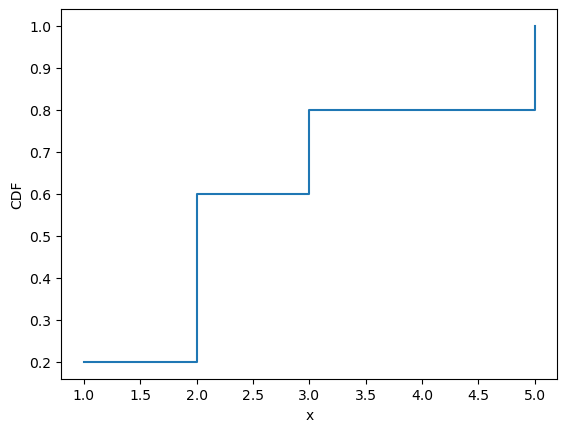

In [37]:
cdf.step()

plt.xlabel("x")
plt.ylabel("CDF")
plt.show()

In [38]:
from empiricaldist import Cdf

cdf_speeds = Cdf.from_seq(speeds)

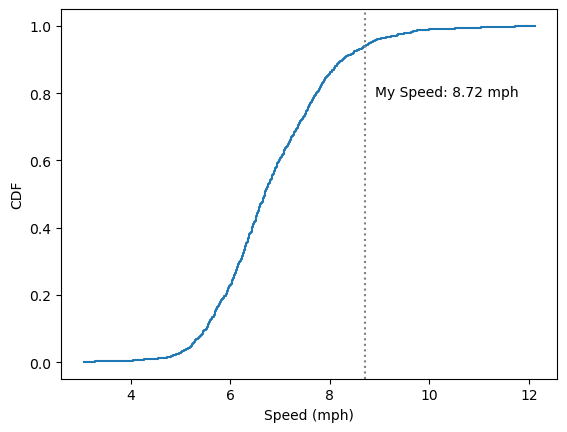

In [52]:
cdf_speeds.step()
plt.axvline(my_speed, ls=":", color="gray")
plt.text(my_speed+0.2, cdf_speeds(my_speed)-0.15, f"My Speed: {round(my_speed, 2)} mph")

plt.xlabel("Speed (mph)")
plt.ylabel("CDF")
plt.show()

In [42]:
cdf_speeds(my_speed) * 100


94.12124923453766

In [56]:
# Inverse -  50% of the field
cdf_speeds.inverse(0.5)

array(6.70391061)

If you have a proportion and you use the inverse CDF to find the corresponding value, the result is called a quantile – so the inverse CDF is sometimes called the quantile function.

## Comparing CDFs

CDFs are especially useful for comparing distributions. As an example, let’s compare the distribution of birth weights for first babies and others. We’ll load the NSFG dataset again, and divide it into three DataFrames: all live births, first babies, and others.

The following cells download the data files and install statadict, which we need to read the data.

In [57]:
import statadict
from nsfg import get_nsfg_groups

live, firsts, others = get_nsfg_groups()

In [59]:
first_weights = firsts["totalwgt_lb"].dropna()
first_weights.mean()

7.201094430437772

In [60]:
other_weights = others["totalwgt_lb"].dropna()
other_weights.mean()

7.325855614973262

In [61]:
first_pmf = Pmf.from_seq(first_weights, name="first")
other_pmf = Pmf.from_seq(other_weights, name="other")

In [62]:
def two_bar_plots(ftab1, ftab2, label_1="Label 1", label_2="Label 2", width=0.45):
    ftab1.bar(align="edge", width=-width, label=label_1)
    ftab2.bar(align="edge", width=width, alpha=0.5, label=label_2)

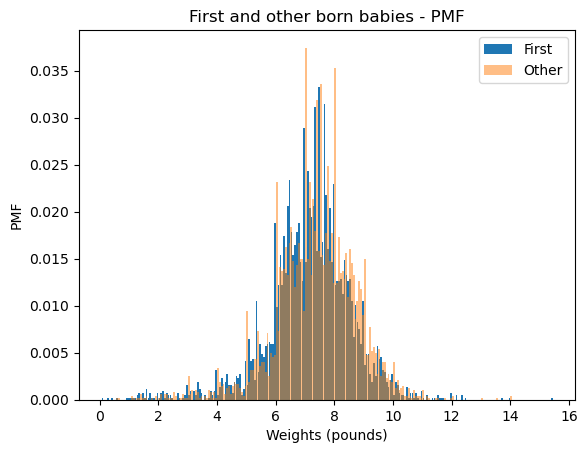

In [67]:
plt.title("First and other born babies - PMF")
two_bar_plots(first_pmf, other_pmf, label_1="First", label_2="Other", width=0.06)

plt.xlabel("Weights (pounds)")
plt.ylabel("PMF")
plt.legend()
plt.show()

In [68]:
# Difficult to compare, plot cdf

first_cdf = first_pmf.make_cdf()
other_cdf = other_pmf.make_cdf()

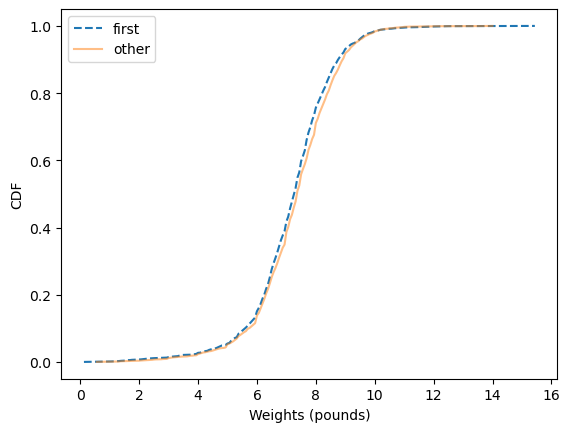

In [70]:
first_cdf.plot(ls="--")
other_cdf.plot(alpha=0.5)

plt.xlabel("Weights (pounds)")
plt.ylabel("CDF")
plt.legend()
plt.show()

This figure makes the shape of the distributions, and the differences between them, much clearer. The curve for first babies is consistently to the left of the curve for others, which indicates that first babies are slightly lighter throughout the distribution – with a larger discrepancy above the midpoint.


## Percentile-Based Statistics

In Chapter 3 we computed the arithmetic mean, which identifies a central point in a distribution, and the standard deviation, which quantifies how spread out the distribution is. And in a previous exercise we computed skewness, which indicates whether a distribution is skewed left or right. One drawback of all of these statistics is that they are sensitive to **outliers**. A single extreme value in a dataset can have a large effect on mean, standard deviation, and skewness.

An alternative is to use statistics that are based on percentiles of the distribution, which tend to be more **robust**, which means that they are less sensitive to outliers. To demonstrate, let’s load the NSFG data again without doing any data cleaning.

In [ ]:
from nsfg import read_nsfg_data
from empiricaldist import Hist

preg = read_nsfg_data()

In [75]:
birthwgt_lb = preg["birthwgt_lb"]
birthwgt_oz = preg["birthwgt_oz"]

In [78]:
Hist.from_seq(birthwgt_oz).tail(5)

,freqs
birthwgt_oz,
14.0,475
15.0,378
97.0,1
98.0,1
99.0,46


In [79]:
Hist.from_seq(birthwgt_lb).tail(5)


,freqs
birthwgt_lb,
15.0,1
51.0,1
97.0,1
98.0,1
99.0,57


In [86]:
## Clean the outliers vs. Not Clean (bogus)

In [87]:
birthwgt_lb_clean = birthwgt_lb.replace([51, 97, 98, 99], np.nan)
birthwgt_oz_clean = birthwgt_oz.replace([97, 98, 99], np.nan)

total_weight_clean = birthwgt_lb_clean + birthwgt_oz_clean / 16

In [88]:
total_weight_bogus = birthwgt_lb + birthwgt_oz / 16

In [90]:
count1, count2 = total_weight_bogus.count(), total_weight_clean.count()
diff = count1 - count2

diff, diff / count2 * 100 
# 49 bogus value, 0.5% of the data

(49, 0.5421553441026776)

In [102]:
# Mean
mean1, mean2 = total_weight_bogus.mean(), total_weight_clean.mean()
print(mean1, mean2)
print(f"Pct diff: {(mean1 - mean2) / mean2 * 100}")
# Minor pct diff in means

7.319680587652691 7.265628457623368
Pct diff: 0.74394294099376


In [103]:
# Standard Deviation
std1, std2 = total_weight_bogus.std(), total_weight_clean.std()
print(std1, std2)
print(f"Pct diff: {round((std1 - std2) / std2 * 100, 2)}%")

# Noticeable 50% diff

2.0960017791618313 1.4082934455690168
Pct diff: 48.83%


In [104]:
def skewness(seq):
    """Compute the skewness of a sequence

    seq: sequence of numbers

    returns: float skewness
    """
    deviations = seq - seq.mean()
    return np.mean(deviations**3) / seq.std(ddof=0) ** 3

In [108]:
#Skewness
skew1, skew2 = skewness(total_weight_bogus), skewness(total_weight_clean)
print(skew1, skew2)

print(f"Pct Diff: {round((skew1 - skew2) / skew2,4)}")


22.251846195422598 -0.5895062687577703
Pct Diff: -38.7466


The skewness of the bogus dataset is off by a factor of almost **40**, and it has the wrong sign! With the outliers added to the data, the distribution is strongly skewed to the **right**, as indicated by **large positive** skewness. But the distribution of the valid data is slightly skewed to the **left**, as indicated by **small negative** skewness.

These results show that a small number of outliers have a moderate effect on the mean, a strong effect on the standard deviation, and a disastrous effect on skewness.

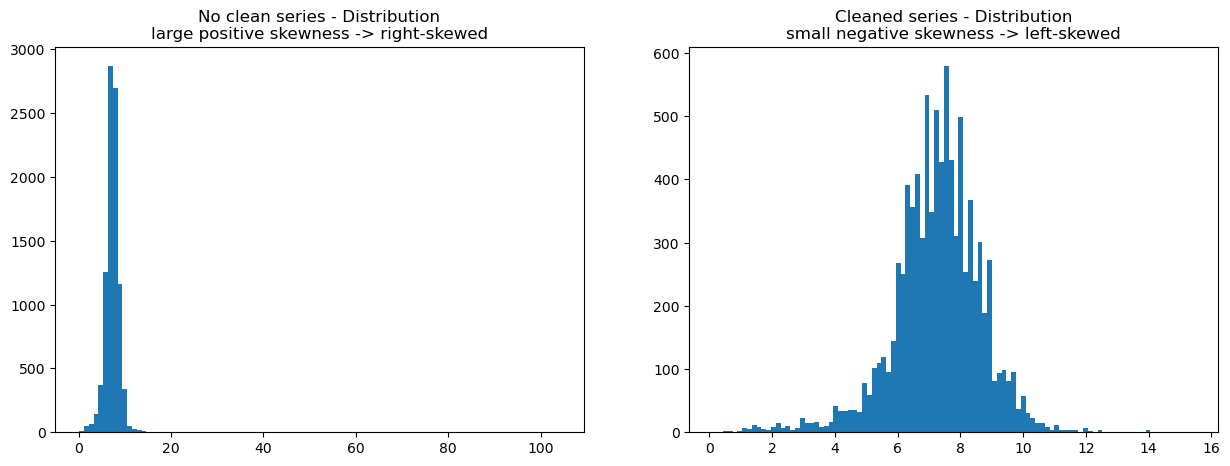

In [134]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

ax[0].hist(total_weight_bogus, bins=100)
ax[0].set_title("No clean series - Distribution\nlarge positive skewness -> right-skewed")
ax[1].hist(total_weight_clean, bins=100)
ax[1].set_title("Cleaned series - Distribution\nsmall negative skewness -> left-skewed")

plt.show()

An alternative is to use statistics based on percentiles. Specifically:

The median, which is the 50th percentile, identifies a central point in a distribution, like the mean.

The interquartile range, which is the difference between the 25th and 75th percentiles, quantifies the spread of the distribution, like the standard deviation.

The quartile skewness uses the quartiles of the distribution (25th, 50th, and 75th percentiles) to quantify the skewness.

In [135]:
cdf_total_weight_bogus = Cdf.from_seq(total_weight_bogus)
cdf_total_weight_clean = Cdf.from_seq(total_weight_clean)

In [136]:
def median(cdf):
    m = cdf.inverse(0.5)
    return m

In [137]:
# Medians
median(cdf_total_weight_bogus), median(cdf_total_weight_clean)

(array(7.375), array(7.375))

The results are identical, so in this case, the outliers have no effect on the median at all. In general, outliers have a smaller effect on the median than on the mean.

The **interquartile range** (IQR) is the difference between the 75th and 25th percentiles. The following function takes a Cdf and returns the IQR.

In [139]:
def iqr(cdf):
    low, high = cdf.inverse([0.25, 0.75])
    return high - low

In [140]:
iqr(cdf_total_weight_bogus), iqr(cdf_total_weight_clean)

(1.625, 1.625)

Finally, here’s a function that computes quartile skewness, which depends on three statistics:

* The median,

* The midpoint of 25th and 75th percentiles, and

* The semi-IQR, which is half of the IQR.

In [141]:
def quartile_skewness(cdf):
    low, median, high = cdf.inverse([0.25, 0.5, 0.75])
    midpoint = (high + low) / 2
    semi_iqr = (high - low) / 2
    return (midpoint - median) / semi_iqr

In [142]:
qskew1 = quartile_skewness(cdf_total_weight_bogus)
qskew2 = quartile_skewness(cdf_total_weight_clean)
qskew1, qskew2

(-0.07692307692307693, -0.07692307692307693)

The small number of outliers in these examples has no effect on the quartile skewness. These examples show that percentile-based statistics are less sensitive to outliers and errors in the data.

## Random Numbers

Cdf objects provide an efficient way to generate random numbers from a distribution. First we generate random numbers from a uniform distribution between 0 and 1. Then we evaluate the inverse CDF at those points. The following function implements this algorithm.

In [144]:
def sample_from_cdf(cdf, n):
    ps = np.random.random(size=n)
    return cdf.inverse(ps)

In [145]:
sample = sample_from_cdf(cdf_speeds, 1001)

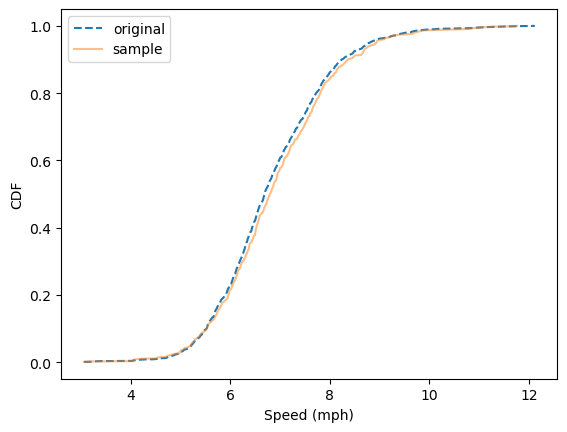

In [148]:
cdf_sample = Cdf.from_seq(sample)

cdf_speeds.plot(label="original", ls="--")
cdf_sample.plot(label="sample", alpha=0.5)

plt.xlabel("Speed (mph)")
plt.ylabel("CDF")
plt.legend()
plt.show()

The sample follows the distribution of the original data. To understand how this algorithm works, consider this question: 

Suppose we choose a random sample from the population of running speeds and look up the percentile ranks of the speeds in the sample. Now suppose we compute the CDF of the percentile ranks. What do you think it will look like?

In [154]:
percentile_ranks = cdf_speeds(sample) * 100

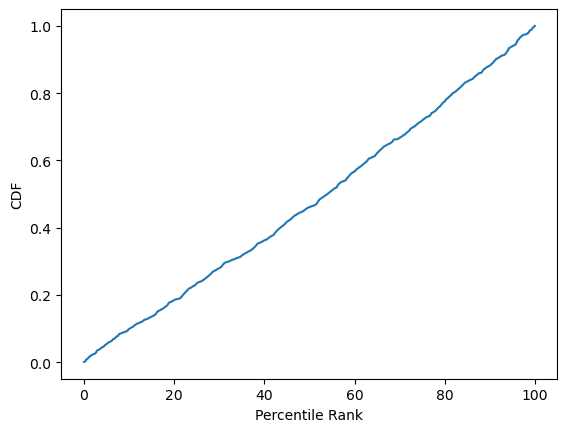

In [157]:
cdf_percentile_rank = Cdf.from_seq(percentile_ranks)
cdf_percentile_rank.plot()

plt.xlabel("Percentile Rank")
plt.ylabel("CDF")
plt.show()

The CDF of the percentile ranks is close to a straight line between 0 and 1. And that makes sense, because in any distribution, the proportion with percentile rank less than 50% is 0.5; the proportion with percentile rank less than 90% is 0.9, and so on.

In [158]:
sample = cdf_speeds.sample(1001)

## Glossary

* percentile rank: The percentage of values in a distribution that are less than or equal to a given quantity.

* percentile: The value in a distribution associated with a given percentile rank.

* cumulative distribution function (CDF): A function that maps a value to the proportion of the distribution less than or equal to that value.

* quantile: The value in a distribution that is greater than or equal to a given proportion of values.

* robust: A statistic is robust if it is less affected by extreme values or outliers.

* interquartile range (IQR): The difference between the 75th and 25th percentiles, used to measure the spread of a distribution.

##  Exercise 4.1

How much did you weigh at birth? If you don’t know, call your mother or someone else who knows. And if no one knows, you can use my birth weight, 8.5 pounds, for this exercise.

Using the NSFG data (all live births), compute the distribution of birth weights and use it to find your percentile rank. If you were a first baby, find your percentile rank in the distribution for first babies. Otherwise use the distribution for others. If you are in the 90th percentile or higher, call your mother back and apologize.

In [223]:
live, firsts, others = get_nsfg_groups()

In [224]:
my_weight = 4.35 * 2.2 #approx 2.2 pound/kg

### Live

In [225]:
birthwgt_lb = live.birthwgt_lb.replace([51, 97, 98, 99], np.nan)
birthwgt_oz = live.birthwgt_oz.replace([97, 98, 99], np.nan)
total_birthwgt = birthwgt_lb+ birthwgt_oz/ 16

In [226]:
cdf_birthwgt = Cdf.from_seq(total_birthwgt)
cdf_birthwgt(my_weight)

array(0.96393007)

### Others

In [227]:
birthwgt_lb = others.birthwgt_lb.replace([51, 97, 98, 99], np.nan)
birthwgt_oz = others.birthwgt_oz.replace([97, 98, 99], np.nan)
total_birthwgt = birthwgt_lb+ birthwgt_oz/ 16

In [228]:
cdf_birthwgt_other = Cdf.from_seq(total_birthwgt)
cdf_birthwgt_other(my_weight)

array(0.96213904)

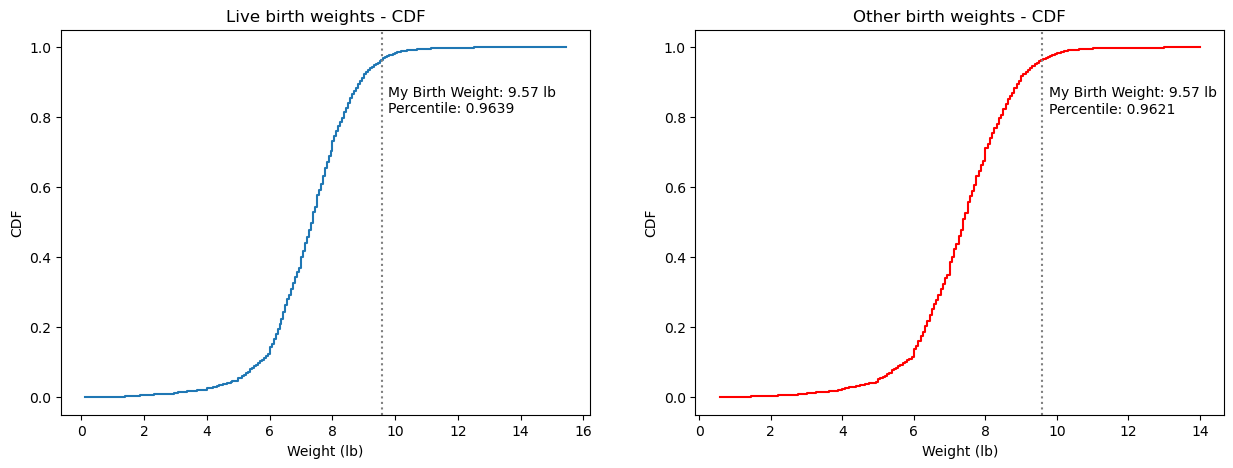

In [231]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

cdf_birthwgt.step(ax=ax[0])
ax[0].set_title("Live birth weights - CDF")
ax[0].axvline(my_weight, ls=":", color="gray")
ax[0].text(my_weight+0.2, cdf_birthwgt(my_weight)-0.15, f"My Birth Weight: {round(my_weight, 2)} lb\nPercentile: {round(cdf_birthwgt(my_weight).item(), 4)}")

ax[0].set_xlabel("Weight (lb)")
ax[0].set_ylabel("CDF")

cdf_birthwgt_other.step(ax=ax[1], c="red")
ax[1].set_title("Other birth weights - CDF")
ax[1].axvline(my_weight, ls=":", color="gray")
ax[1].text(my_weight+0.2, cdf_birthwgt_other(my_weight)-0.15, f"My Birth Weight: {round(my_weight, 2)} lb\nPercentile: {round(cdf_birthwgt_other(my_weight).item(), 4)}")

ax[1].set_xlabel("Weight (lb)")
ax[1].set_ylabel("CDF")

plt.show()

## Exercise 4.2

For live births in the NSFG dataset, the column babysex indicates whether the baby was male or female. We can use query to select the rows for male and female babies.

Make Cdf objects that represent the distribution of birth weights for male and female babies. Plot the two CDFs. What are the differences in the shape and location of the distributions?

If a male baby weighs 8.5 pounds, what is his percentile rank? What is the weight of a female baby with the same percentile rank?

In [235]:
live.birthwgt_lb = live.birthwgt_lb.replace([51, 97, 98, 99], np.nan)
live.birthwgt_oz = live.birthwgt_oz.replace([97, 98, 99], np.nan)
live["total_birthwgt"] = birthwgt_lb+ birthwgt_oz/ 16

In [236]:
male = live.query("babysex == 1")
female = live.query("babysex == 2")
len(male), len(female)

(4641, 4500)

In [237]:
male_pmf = Pmf.from_seq(male.total_birthwgt, name="first")
female_pmf = Pmf.from_seq(female.total_birthwgt, name="other")

In [238]:
# Difficult to compare, plot cdf

male_cdf = male_pmf.make_cdf()
female_cdf = female_pmf.make_cdf()

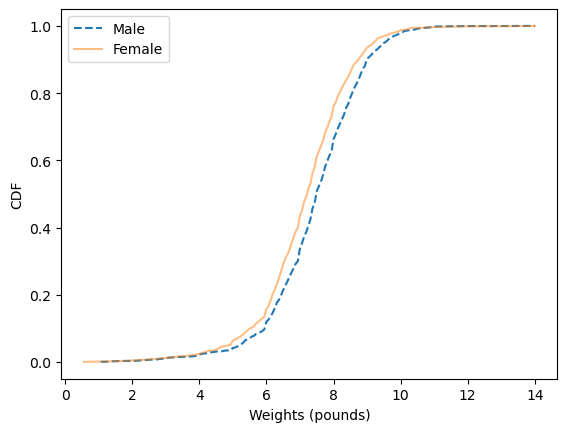

In [242]:
male_cdf.plot(ls="--", label="Male")
female_cdf.plot(alpha=0.5, label="Female")

plt.xlabel("Weights (pounds)")
plt.ylabel("CDF")
plt.legend()
plt.show()

In [247]:
print(f"Male percentile rank: {male_cdf(8.5)}")
print(f"Female percentile rank: {female_cdf(8.5)}")

Male percentile rank: 0.7867616254713031
Female percentile rank: 0.8618881118881117


## Exercise 4.3


From the NSFG dataset pregnancy data, select the agepreg column and make a Cdf to represent the distribution of age at conception for each pregnancy. Use the CDF to compute the percentage of ages less than or equal to 20, and the percentage less than or equal to 30. Use those results to compute the percentage between 20 and 30.

In [253]:
preg = read_nsfg_data()
preg["agepreg"] /= 100.0

In [254]:
cdf_age = Cdf.from_seq(preg.agepreg)

In [264]:
age_20 = cdf_age(20)
age_30 = cdf_age(30)

print(f"Age 20 Percentile: {age_20}\nAge 30 Percentile: {age_30}")
print(f"Diff: {age_30 - age_20}")

Age 20 Percentile: 0.24718676837096895
Age 30 Percentile: 0.8046220074012537
Diff: 0.5574352390302847


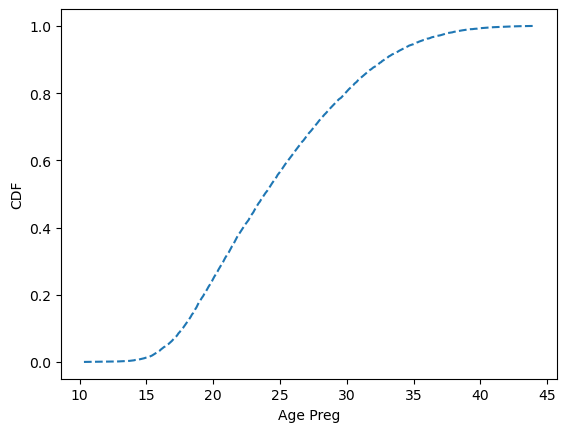

In [266]:
cdf_age.plot(ls="--")

plt.xlabel("Age Preg")
plt.ylabel("CDF")
plt.show()

## Exercise 4.4

Here are the running speeds of the people who finished the James Joyce Ramble, described earlier in this chapter.

In [267]:
speeds = results["MPH"].values

In [ ]:
cdf_speeds = Cdf.from_seq(speeds)

In [270]:
# Medians
median(cdf_speeds)

array(6.70391061)

In [271]:
iqr(cdf_speeds)

1.4865637507146943

In [ ]:
skewness(speeds)
# Right skewed slightly

0.6341408164866873

In [272]:
qskew1 = quartile_skewness(cdf_speeds)
qskew1

0.13450795015040942

##  Exercise 4.5

The numbers generated by np.random.random are supposed to be uniform between 0 and 1, which means that the CDF of a sample should be a straight line. Let’s see if that’s true. Here’s a sample of 1001 numbers. Plot the CDF of this sample. Does it look like a straight line?

In [275]:
t = np.random.random(1001)

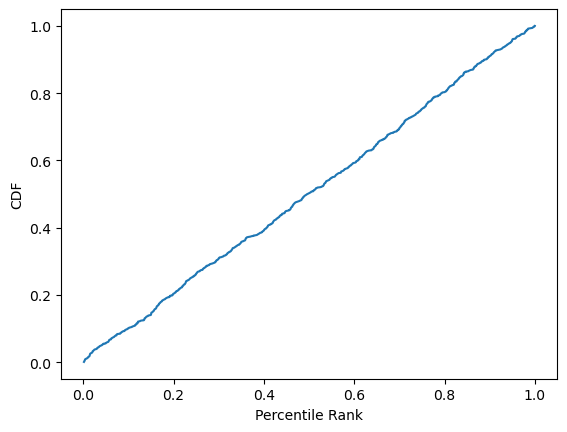

In [277]:
cdf_t = Cdf.from_seq(t)
cdf_t.plot()

plt.xlabel("Percentile Rank")
plt.ylabel("CDF")
plt.show()